In [99]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.backend import concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time
from imagePreprocess import getImagesVarAndMean

In [44]:
# TODO:
# find how to use multithreading in jupyter on windows
# unet
# standardize images
dataDir = 'data/resized/'

In [45]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [46]:
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

(1008, 1600, 3)


In [47]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


In [77]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation)
    '''
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [95]:
params = {'dim': (128, 128),
          'batch_size': 64,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
print('trainSize', trainSize)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape )

#todo change to load hsv

dataset size 202599
trainSize 20259
train len 20259
val len 4051
(64, 128, 128, 2)


In [109]:
def createModel(input_shape):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    mul = 1
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv5 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    
    up6 = Conv2D(64*mul, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    merge6 = concatenate([conv3, up6], axis=3)
    conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2, up7], axis=3)
    conv7 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1, up8], axis=3)
    conv8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    # todo change to sigmoid
    conv8 = Conv2D(2, 1, activation = 'relu')(conv8)
    
    model = Model(inputs=inputs, outputs=conv8)
    
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'])
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_589 (Conv2D)             (None, 128, 128, 16) 160         input_32[0][0]                   
__________________________________________________________________________________________________
conv2d_590 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_589[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_93 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_590[0][0]                 
__________________________________________________________________________________________________
conv2d_591

In [97]:
x = model.layers[0]
x.input

<tf.Tensor 'input_30:0' shape=(?, 128, 128, 1) dtype=float32>

In [110]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet2xconv_biggertrain']
NAME = f"test-tensorboard-{ currTime }-layers-" + "_".join(str(l) for l in layers)
print(NAME)

model = createModel(params['dim'])
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
#mode.fit(X, y, batch_size=32, epochs=10, validation_split=0.2, callbacks=[tensorboard])

test-tensorboard-09-05-2019-23-15-46-layers-unet2xconv_biggertrain
Epoch 1/1
316/316 [==============================] - 87s 276ms/step - loss: 4037.5074 - mean_absolute_error: 44.1989 - mean_squared_error: 4037.5074 - val_loss: 3724.5785 - val_mean_absolute_error: 42.4242 - val_mean_squared_error: 3724.5785


Epoch 1/1
316/316 [==============================] - 83s 261ms/step - loss: 2640.4877 - mean_absolute_error: 38.0815 - mean_squared_error: 2640.4877 - val_loss: 2623.3466 - val_mean_absolute_error: 37.9285 - val_mean_squared_error: 2623.3467
elapsed time: 86.53910636901855
xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 206.23485 68.83622
0.0 206.23485 68.83622
hue 48 129 80.1875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


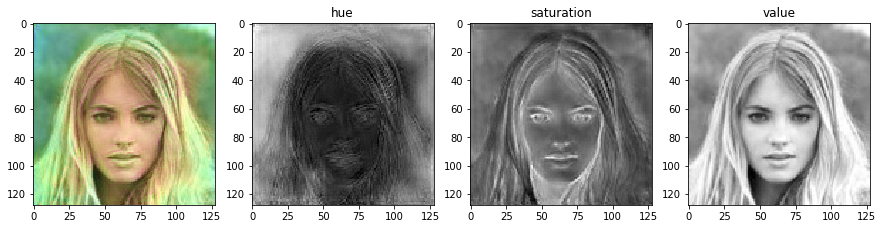

Epoch 1/1
316/316 [==============================] - 82s 260ms/step - loss: 2586.4851 - mean_absolute_error: 37.5857 - mean_squared_error: 2586.4851 - val_loss: 2584.6350 - val_mean_absolute_error: 37.2420 - val_mean_squared_error: 2584.6351
elapsed time: 86.13354682922363
xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 217.43826 67.89401
0.0 217.43826 67.89401
hue 2 122 64.390625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


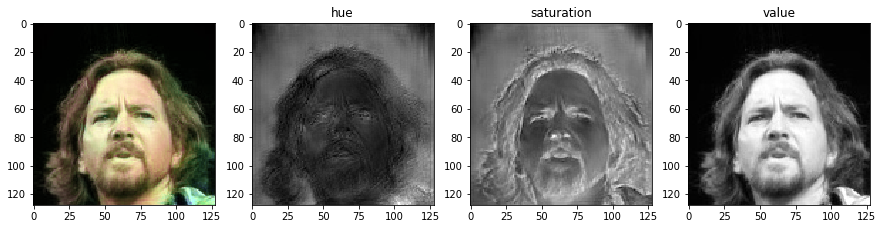

Epoch 1/1
316/316 [==============================] - 82s 258ms/step - loss: 2539.5568 - mean_absolute_error: 37.1451 - mean_squared_error: 2539.5568 - val_loss: 2543.9379 - val_mean_absolute_error: 36.7127 - val_mean_squared_error: 2543.9378
elapsed time: 85.8381462097168
xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 215.21074 60.54561
0.0 215.21074 60.54561
hue 21 74 45.8125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


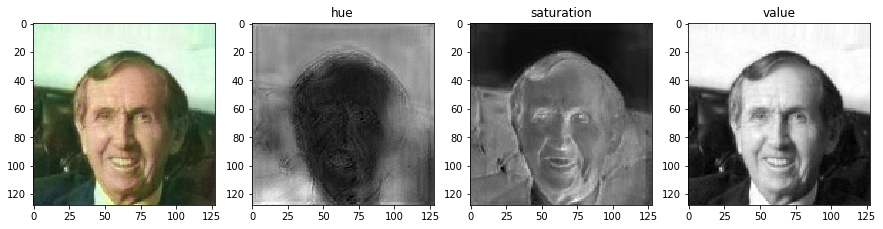

Epoch 1/1
316/316 [==============================] - 83s 262ms/step - loss: 2483.7027 - mean_absolute_error: 36.6383 - mean_squared_error: 2483.7027 - val_loss: 2521.1258 - val_mean_absolute_error: 37.0879 - val_mean_squared_error: 2521.1258
elapsed time: 87.12578463554382
xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.44440016 216.50276 54.999847
0.44440016 216.50276 54.999847
hue 19 55 37.33203125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


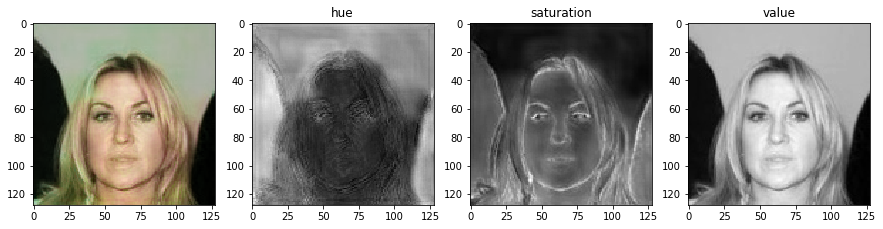

Epoch 1/1
316/316 [==============================] - 83s 262ms/step - loss: 2447.6426 - mean_absolute_error: 36.3208 - mean_squared_error: 2447.6425 - val_loss: 2508.0750 - val_mean_absolute_error: 35.7929 - val_mean_squared_error: 2508.0750
elapsed time: 86.86199975013733
xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 183.65709 50.88221
0.0 183.65709 50.88221
hue 10 65 38.17578125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


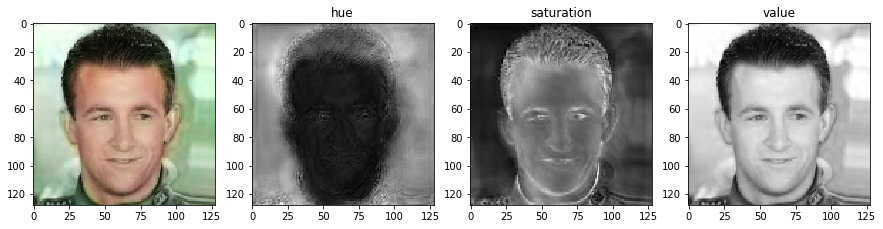

In [113]:
for i in range(1,6):
    start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    elapsed_time = time.time() - start_time
    print("elapsed time:",elapsed_time)
    predictFromImage(f'data/resized/{i+18:06}.jpg', True)

In [13]:
def showImgFromPredict(hs, v, showDetails=False):
    '''hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    print('h',h.shape,'s',s.shape,'v',v.shape)
    print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
    
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()

In [14]:
def predictFromImage(img, showDetails=False):
    X, Y = validation_generator[1]
    print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    #print(inX.shape,inY.shape)
    inX, inY = inX[None,...,None], inY[None,:]
    #print(inX.shape,inY.shape)
    X, Y = X[10][None,:], Y[0][None,:]
    #print(X.shape, Y.shape)

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    #print(X.dtype, X.min(), X.max(), X.mean())
    #predY = int(predY)
    print('predyshape',predY.shape)
    print(predY.min(), predY.max(), predY.mean() )
    print(predY.min(), predY.max(), predY.mean() )
    predY = predY
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    #print(predY.min(), predY.max(), predY.mean() )
    #predY[:,0] += 0
    #predY[0,0] = 0
    hue = predY[:,0]
    print('hue',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 239.00594 64.46264
0.0 239.00594 64.46264
hue 37 112 69.53125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


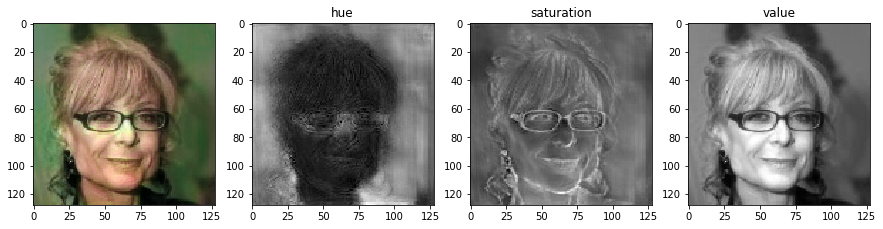

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 252.60043 63.67126
0.0 252.60043 63.67126
hue 27 126 66.609375
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


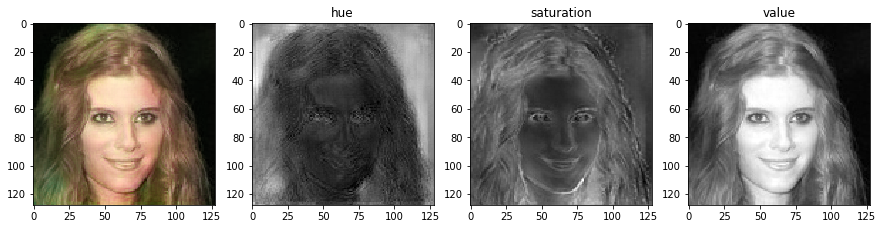

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 226.43231 66.76987
0.0 226.43231 66.76987
hue 27 87 62.5078125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


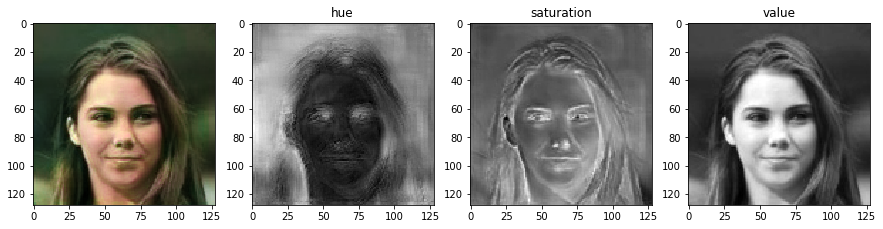

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 204.34776 61.583244
0.0 204.34776 61.583244
hue 23 84 54.9765625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


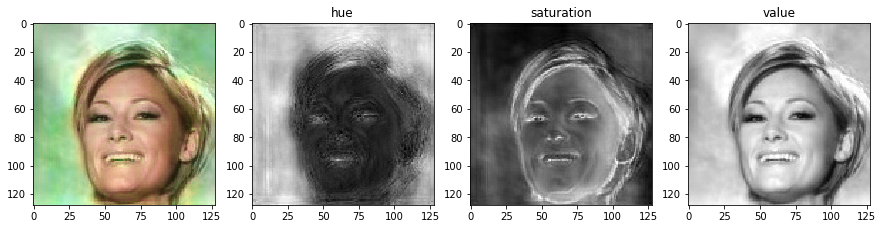

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 227.24469 46.599777
0.0 227.24469 46.599777
hue 0 95 19.5
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


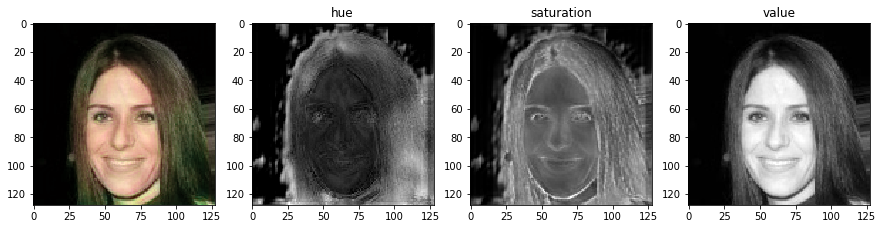

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.14672506 179.92528 50.98168
0.14672506 179.92528 50.98168
hue 7 107 42.19140625
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


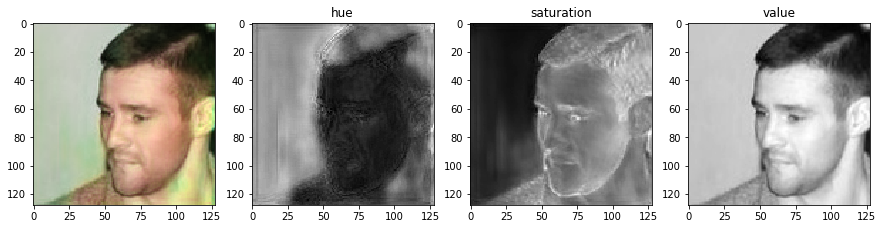

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.4255584 246.8327 70.64755
0.4255584 246.8327 70.64755
hue 33 151 77.73046875
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


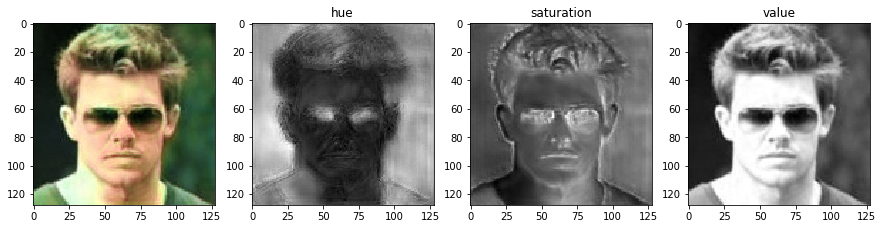

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 214.59119 52.96067
0.0 214.59119 52.96067
hue 10 92 56.78125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


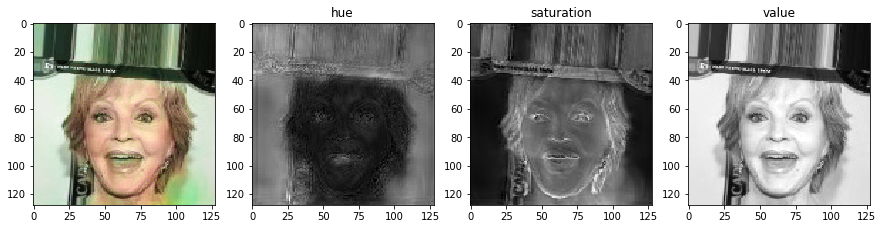

xshape (64, 128, 128, 1) yshape (64, 128, 128, 2)
predyshape (1, 128, 128, 2)
0.0 221.77745 59.830215
0.0 221.77745 59.830215
hue 19 100 51.453125
h (128, 128) s (128, 128) v (128, 128)
uint8 uint8 uint8


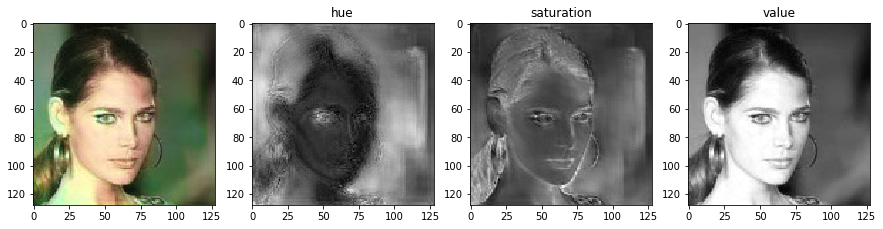

In [114]:
for i in range(1,10):
    predictFromImage(f'data/resized/{i+trainSize+98:06}.jpg', True)


In [68]:
training_generator[0][0].mean()

-0.0002184260861182591

In [93]:
import tensorflow.keras.backend as K

def customLoss(yTrue, yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))